# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [1]:
pip install nltk

In [2]:
import nltk

nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [30]:
from nltk.corpus import brown
from collections import defaultdict, Counter

word_frequency = Counter(brown.words())

In [62]:
word_frequency

Counter({'The': 7258,
         'Fulton': 17,
         'County': 85,
         'Grand': 18,
         'Jury': 4,
         'said': 1943,
         'Friday': 60,
         'an': 3542,
         'investigation': 43,
         'of': 36080,
         "Atlanta's": 4,
         'recent': 167,
         'primary': 93,
         'election': 72,
         'produced': 90,
         '``': 8837,
         'no': 1781,
         'evidence': 201,
         "''": 8789,
         'that': 10237,
         'any': 1301,
         'irregularities': 8,
         'took': 425,
         'place': 528,
         '.': 49346,
         'jury': 63,
         'further': 194,
         'in': 19536,
         'term-end': 1,
         'presentments': 1,
         'the': 62713,
         'City': 134,
         'Executive': 9,
         'Committee': 88,
         ',': 58334,
         'which': 3540,
         'had': 5102,
         'over-all': 35,
         'charge': 120,
         'deserves': 16,
         'praise': 17,
         'and': 27915,
         'than

In [42]:
total_frequency = len(brown.words())

In [31]:
sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

In [48]:
coverages = []
sum = 0

for (_, frequency) in sorted_word_frequency:
  sum += frequency
  coverages.append(sum/total_frequency * 100)

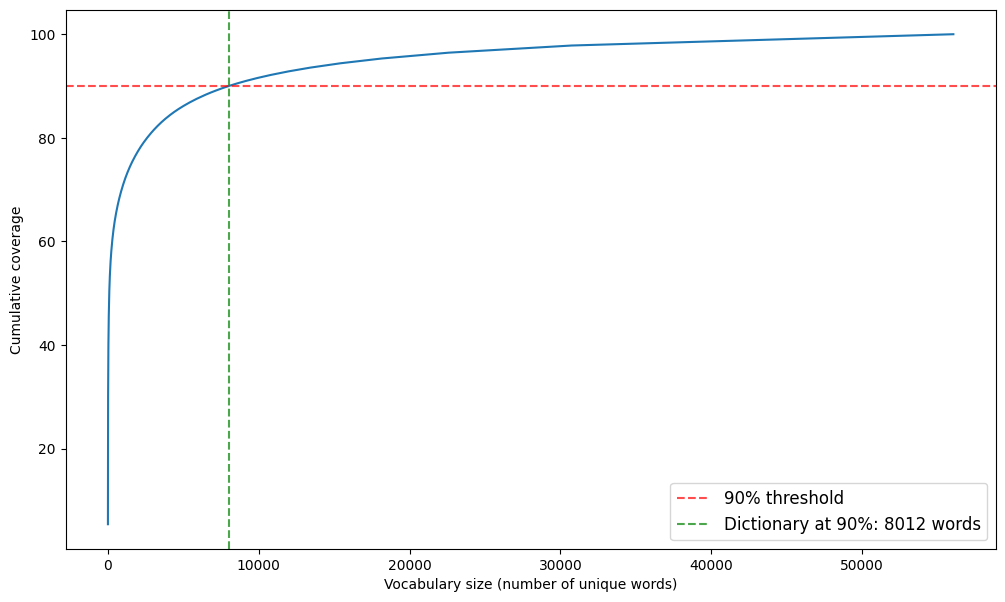

In [64]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 7))
x = range(1, len(sorted_word_frequency) + 1)
plt.plot(x, coverages)

ind_90 = next(i for i, cov in enumerate(coverages) if cov >= 90)
vocab_size_90 = ind_90 + 1
plt.axhline(y=90, color='r', linestyle='--', alpha=0.7, label='90% threshold')
plt.axvline(x=vocab_size_90, color='g', linestyle='--', alpha=0.7,
            label=f'Dictionary at 90%: {vocab_size_90} words')

plt.xlabel('Vocabulary size (number of unique words)')
plt.ylabel('Cumulative coverage')
plt.legend(fontsize=12)
plt.show()

###Question 1 Answer: Why the coverage slows down the increase as the vocabulary size increases?
- It slows down because frequency of words decreases as the vocabulary size increases (since we arranged items in descending order, i.e the most frequent words are placed in the beginning of sorted_word_frequency while the rarest words are placed in the tail of sorted_word_frequency)

###Question 2 Answer: Which empirical law explains the slowing down increase of the coverage?
- Zipf's Law. This law states that the frequency of a word is inversely proportional to its rank (f(r) ∝ 1/rᵃ). Because the most frequent words cover most of the text, adding rare words gives diminishing returns, causing the coverage growth to slow down.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [80]:
class BPETokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.merges = {}  # Dictionary for storing merge rules: (token1, token2) -> new_token
        self.vocab = set()


    def _get_stats(self, word_freqs: dict) -> dict:
        """
        An auxiliary method for calculating the frequency of token pairs.

        Args:
            word_freqs (dict): A dictionary where the key is a tuple of tokens (a word), the value is the frequency of the word.

        Returns:
            dict: Dictionary of frequency pairs {(token1, token2): frequency}.
        """
        pairs = defaultdict(int)
        for word_tuple, freq in word_freqs.items():
            # We go through the characters in the word and count the pairs
            for i in range(len(word_tuple) - 1):
                pair = (word_tuple[i], word_tuple[i + 1])
                pairs[pair] += freq
        return pairs

    def _merge_vocab(self, pair: tuple, word_freqs: dict) -> dict:
        """
        An auxiliary method for applying fusion to a dictionary of word frequencies.
        Replaces the pair (a, b) with a new token (ab) in all words.

        Args:
            pair (tuple): A pair of tokens to merge (token1, token2).
            word_freqs (dict): The current dictionary of word frequencies.

        Returns:
            dict: Updated dictionary of word frequencies.
        """
        new_word_freqs = {}
        first, second = pair
        new_token = first + second

        for word_tuple, freq in word_freqs.items():
            # If there is no pair in the word, skip it
            if first not in word_tuple or second not in word_tuple:
                new_word_freqs[word_tuple] = freq
                continue

            # Creating a new list of tokens for the word
            new_tuple = []
            i = 0
            while i < len(word_tuple):
                # Check for a pair at the current position
                if i < len(word_tuple) - 1 and word_tuple[i] == first and word_tuple[i+1] == second:
                    new_tuple.append(new_token)
                    i += 2
                else:
                    new_tuple.append(word_tuple[i])
                    i += 1
            new_word_freqs[tuple(new_tuple)] = freq

        return new_word_freqs


    def train(self, word_frequency: dict, corpus: list):
        """
        Training a BPE tokenizer on a corpus of texts.

        Process:
        1. Counting the frequency of words in the corpus.
        2. Splitting words into symbols.
        3. Iteratively merge the most frequent pairs until vocab_size is reached.

        Args:
            word_frequency (dict): A dictionary in which the word is the key and the frequency is the value.
            corpus (list): A list of lines (sentences) for training.
        """
        print("The beginning of BPE training...")

        # Convert words into tuples of characters + end of word
        # Example: "low" -> ('l', 'o', 'w', '</w>')
        self.word_freqs = {
            tuple(list(word) + ['</w>']): count
            for word, count in word_frequency.items()
        }

       # Initialize the basic dictionary with unique characters
        self.vocab = set()
        for word_tuple in self.word_freqs.keys():
            for char in word_tuple:
                self.vocab.add(char)

        # The cycle continues until the dictionary size is smaller than the target
        while len(self.vocab) < self.vocab_size:
            # We get the frequencies of all pairs
            pairs = self._get_stats(self.word_freqs)

            if not pairs:
                break # There are no more pairs to merge

            # Finding the most frequent pair
            best_pair = max(pairs, key=pairs.get)

            # Creating a new token
            new_token = best_pair[0] + best_pair[1]

            # Updating the dictionary of tokens and the rules of merging
            self.merges[best_pair] = new_token
            self.vocab.add(new_token)

            # We apply the merge to the entire corpus (in our case, to the frequency dictionary)
            self.word_freqs = self._merge_vocab(best_pair, self.word_freqs)

            if len(self.vocab) % 100 == 0:
                print("Dictionary Size:", len(self.vocab))

        print(f"The training is completed. The total size of the dictionary: {len(self.vocab)}")

    def tokenize(self, text: str) -> list:
        """
        Tokenization of text using trained BPE rules.

        Args:
            text (str): The input string for tokenization.

        Returns:
            list: A list of tokens (strings).
        """
        if not self.merges:
            raise ValueError("The tokenizer has not been trained yet. Run the method.train() first.")

        # Breaking the text into words
        words = text.strip().split()
        final_tokens = []

        for word in words:
            # Initial splitting of a word into characters + end of a word
            word_tokens = list(word) + ['</w>']

            # In this approach, we go through all the rules of merging in the order of their priority (as they were learned).
            while True:
                # We find all possible pairs in the current word split
                current_pairs = []
                for i in range(len(word_tokens) - 1):
                    current_pairs.append((word_tokens[i], word_tokens[i+1]))

                if not current_pairs:
                    break

                # Find a pair in the current word that is in self.merges
                # and if there are several of them -> select the one that was added earlier.
                bigram_to_merge = None
                min_rank = float('inf')
                merges_keys = list(self.merges.keys())

                for pair in current_pairs:
                    if pair in self.merges:
                        rank = merges_keys.index(pair)
                        if rank < min_rank:
                            min_rank = rank
                            bigram_to_merge = pair

                if bigram_to_merge is None:
                    break # There are no more pairs to merge

                # Merging the found pair
                first, second = bigram_to_merge
                new_token = self.merges[bigram_to_merge]

                new_word_tokens = []
                i = 0
                while i < len(word_tokens):
                    if i < len(word_tokens) - 1 and word_tokens[i] == first and word_tokens[i+1] == second:
                        new_word_tokens.append(new_token)
                        i += 2
                    else:
                        new_word_tokens.append(word_tokens[i])
                        i += 1
                word_tokens = new_word_tokens

            final_tokens.extend(word_tokens)

        return final_tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [81]:
tokenizer = BPETokenizer(vocab_size_90)

tokenizer.train(word_frequency, brown.words())

Начало обучения BPE...
Размер словаря: 100, последнее слияние: ('o', '</w>') -> o</w>
Размер словаря: 200, последнее слияние: ('t', 'r') -> tr
Размер словаря: 300, последнее слияние: ('om', 'e</w>') -> ome</w>
Размер словаря: 400, последнее слияние: ('n', 'ow</w>') -> now</w>
Размер словаря: 500, последнее слияние: ('o', 'f') -> of
Размер словаря: 600, последнее слияние: ('al', 's</w>') -> als</w>
Размер словаря: 700, последнее слияние: ('el', 'op') -> elop
Размер словаря: 800, последнее слияние: ('bo', 'th</w>') -> both</w>
Размер словаря: 900, последнее слияние: ('ol', 'og') -> olog
Размер словаря: 1000, последнее слияние: ('s', 'al') -> sal
Размер словаря: 1100, последнее слияние: ('dis', 'c') -> disc
Размер словаря: 1200, последнее слияние: ('ch', 'ing</w>') -> ching</w>
Размер словаря: 1300, последнее слияние: ('ou', "'") -> ou'
Размер словаря: 1400, последнее слияние: ('gener', 'al</w>') -> general</w>
Размер словаря: 1500, последнее слияние: ('n', 'on') -> non
Размер словаря: 16

In [85]:
sents = brown.sents()[:1000]
corpus_text = [" ".join(sent) for sent in sents]

In [88]:
fertilities = []
lengths = []
for i, sent in enumerate(corpus_text):
    tokens = tokenizer.tokenize(sent)
    fertilities.append(len(tokens) / len(sents[i]))
    lengths.append(len(tokens))

In [89]:
import numpy as np

fertilities = np.asarray(fertilities)
lengths = np.asarray(lengths)

In [101]:
print('Mean of Fertility:', fertilities.mean())
print('Standard deviation of Fertility:', fertilities.std())
print('Mean of Length:', lengths.mean())
print('Standard deviation of Length:', lengths.std())

Mean of Fertility: 1.3165245968717225
Standard deviation of Fertility: 0.3059606871250672
Mean of Length: 27.905
Standard deviation of Length: 15.394024002839544


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.